In [1]:
from importlib import reload
import parsing
import models
import model_interface
import visualization
import util
import config
reload(parsing)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

<module 'config' from '/home/deus/Documents/trajectory-prediction/config.py'>

In [2]:
# file_path = "data/small.csv"
file_path = "data/medium_aa.csv"
# file_path = "data/atc-20121114.csv"

train_data, eval_data, test_data = parsing.parse_atc_day(file_path, train_ratio=0.9, eval_ratio=0.1)
eval_data_x, eval_data_goals, eval_data_y = eval_data
print(eval_data_goals.shape)
print(eval_data_goals[0])

  1%|          | 7/1224 [00:00<00:17, 69.74it/s]

           time       id      x      y         z  velocity  motion_angle  \
0  1.352853e+09  9315400  39830 -22779  1704.245   823.082        -0.499   
1  1.352853e+09  9330400  34873 -17618  1467.723  1280.126         2.821   
2  1.352853e+09  9330600  -9670   7396  1230.397  1095.896         2.322   
3  1.352853e+09  9315400  39848 -22802  1704.947   903.930        -0.648   
4  1.352853e+09  9330400  34830 -17590  1466.868  1302.011         2.751   

   facing_angle  
0        -0.708  
1         2.799  
2         2.357  
3        -0.732  
4         2.748  
time    float64
id        int64
x         int64
y         int64
dtype: object
           time       id      x      y
0  1.352853e+09  9315400  39830 -22779
1  1.352853e+09  9330400  34873 -17618
2  1.352853e+09  9330600  -9670   7396
3  1.352853e+09  9315400  39848 -22802
4  1.352853e+09  9330400  34830 -17590
0   2012-11-14 00:33:08.708000000
1   2012-11-14 00:33:08.708000000
2   2012-11-14 00:33:08.708000000
3   2012-11-14 00:33:

100%|██████████| 1224/1224 [00:17<00:00, 71.66it/s]


Dividing 697 human trajectories: 627 training, 70 eval, 0 test
train (224340, 40, 2) float64 (224340, 25) float32 (224340, 40, 2) float64
eval (24880, 40, 2) float64 (24880, 25) float32 (24880, 40, 2) float64
(24880, 25)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.]


In [3]:
reload(models)

model = None
print(train_data[0].shape)
# model, _ = models.simple_lstm(train_data, eval_data)
model, _ = models.simple_cnn(train_data, eval_data)
# model, _ = models.simple_lstm_goal(train_data, eval_data)

model_prob, _ = models.simple_cnn_dropout(train_data, eval_data)


# model_no_goal, _ = models.simple_lstm(train_data, eval_data)
# model_goal, _ = models.simple_lstm_goal(train_data, eval_data)

(224340, 40, 2)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 2)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 64)            448       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 32)            6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                46160     
_________________________________________________________________
dense_1 (Dense)              (None, 80)      

In [9]:
reload(models)
model_prob, _ = models.simple_cnn_dropout(train_data, eval_data)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 2)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 38, 32)            224       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                48720     
_________________________________________________________________
reshape_2 (Reshape)          (None, 40, 2)             0   

In [5]:
# print("Deterministic model")
# for _ in range(5):
#     print(model_interface.predict_once(model, eval_data_x[0])[1])

# print(model.summary())

# print("Bayesian NN")
# for _ in range(5):
#     print(model_interface.predict_once(model_prob, eval_data_x[0])[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 32)            224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 608)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                48720     
_________________________________________________________________
reshape (Reshape)            (None, 40, 2)             0         
Total params: 48,944
Trainable params: 48,944
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_x, eval_y=eval_data_y, filepath='goal_baseline')
# model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_model_errors')

MED: 0.04966662976588962
FDE: 0.09358999068223993


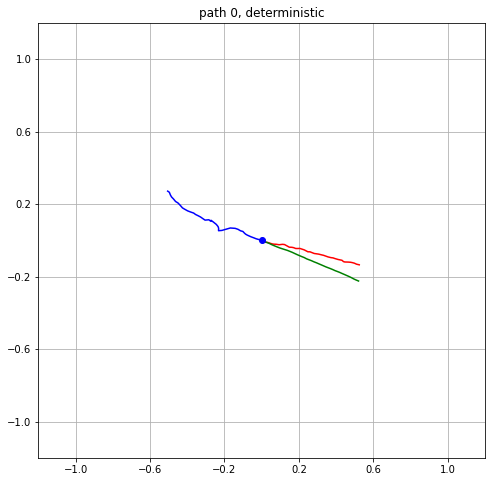

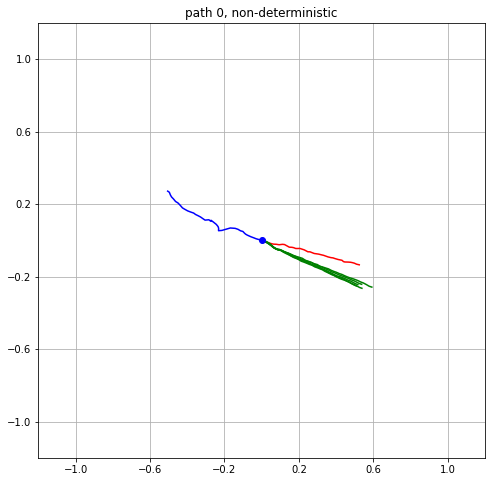

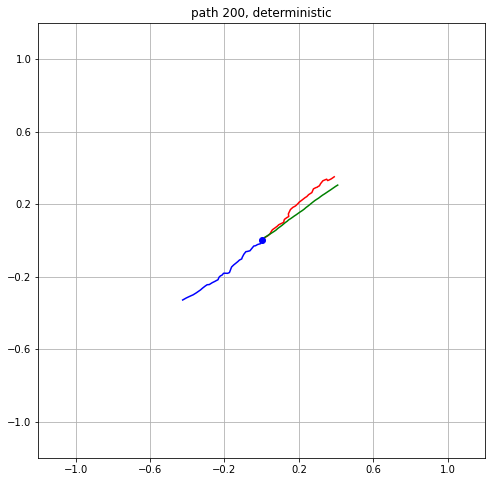

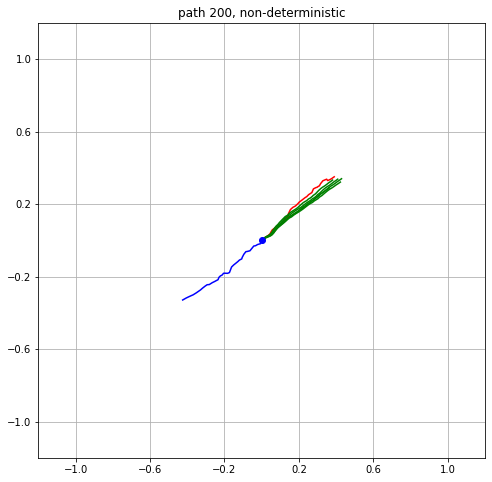

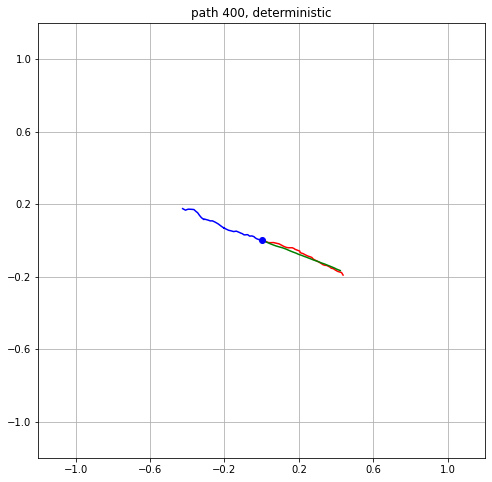

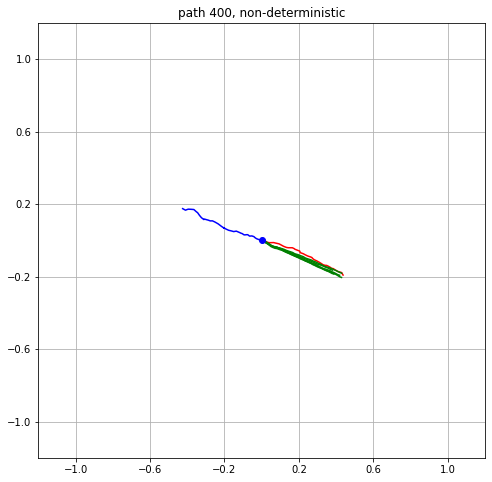

In [4]:
N = 0
multiplier = 200
amount = 3

for i in range(amount):
    n = N + multiplier * i

    x = eval_data_x[n]
    y = eval_data_y[n]

    predictions = [model_interface.predict_once(model, x)]
    visualization.draw_path(eval_data_x[n], eval_data_y[n], predictions=predictions, name=f"path {n}, deterministic")
    predictions = model_interface.prediction_sampling(model_prob, x, samples=5)
    visualization.draw_path(eval_data_x[n], eval_data_y[n], predictions=predictions, name=f"path {n}, non-deterministic")

Goal 2, 0: 1.00


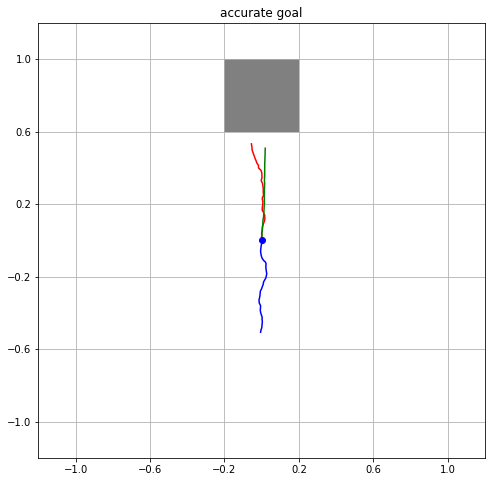

Goal 2, 0: 0.90
Goal 3, 1: 0.10


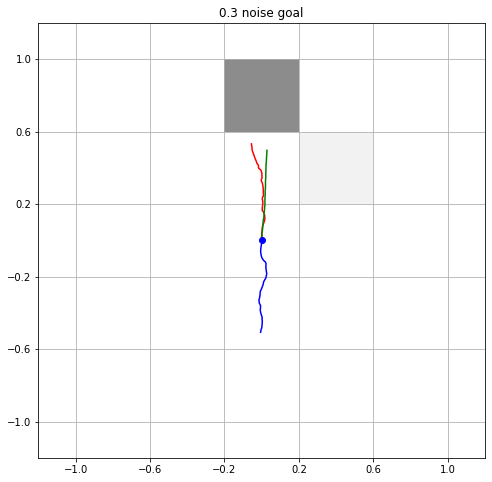

Goal 2, 0: 0.70
Goal 1, 0: 0.10
Goal 2, 1: 0.10
Goal 3, 1: 0.10


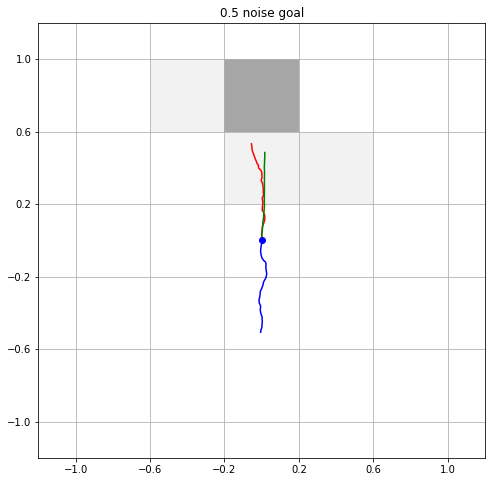

Goal 2, 0: 0.40
Goal 1, 0: 0.20
Goal 1, 1: 0.20
Goal 2, 1: 0.10
Goal 3, 1: 0.10


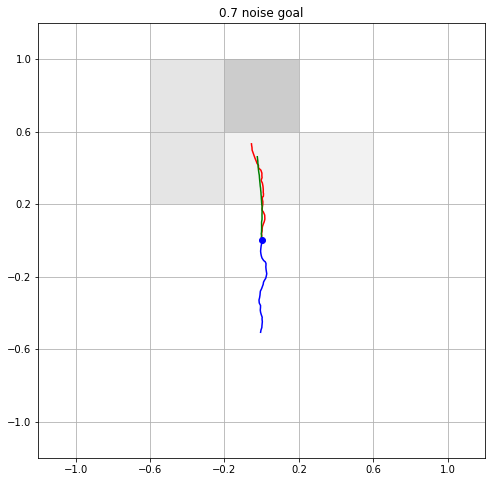

Goal 3, 1: 0.40
Goal 3, 0: 0.20
Goal 2, 1: 0.20
Goal 1, 0: 0.10
Goal 2, 0: 0.10
Goal 1, 1: 0.10


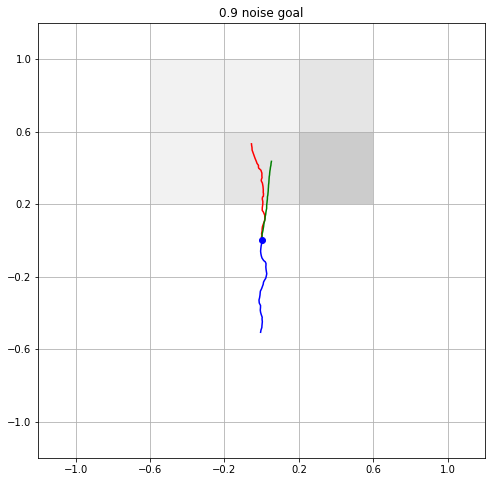

In [43]:
# compare prediction efficency with goals with various noise levels
N = 1000

eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model, name="accurate goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.3)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.3 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.5)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.5 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.7)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.7 noise goal")

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.9)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
visualization.draw_path(eval_data_x[N], eval_data_y[N], inaccurate_goals[N], prediction_model=model, name="0.9 noise goal")

In [48]:
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_noise_0_0')

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.3)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_noise_0_3')

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.5)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_noise_0_5')

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.7)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_noise_0_7')

inaccurate_goals = util.apply_randomness_to_adjacent_goal_predictions(eval_data_goals, amount=0.9)
eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, inaccurate_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_noise_0_9')

MED: 0.04022140546204346
FDE: 0.06597747260414283
MED: 0.04192719297606437
FDE: 0.07061376601379137
MED: 0.043691483300276675
FDE: 0.07511971939235268
MED: 0.04592443480722182
FDE: 0.08082917048715287
MED: 0.047317980607863096
FDE: 0.0840148221983325


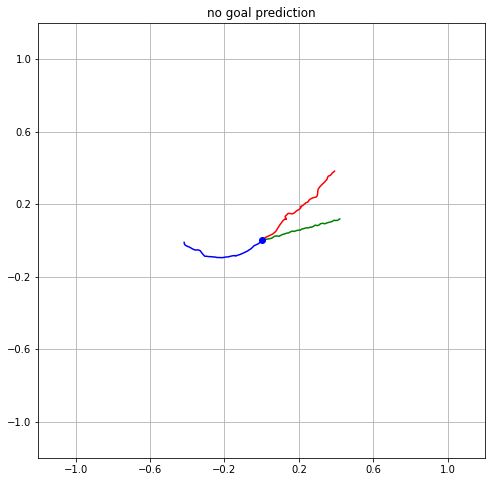

9 4 1


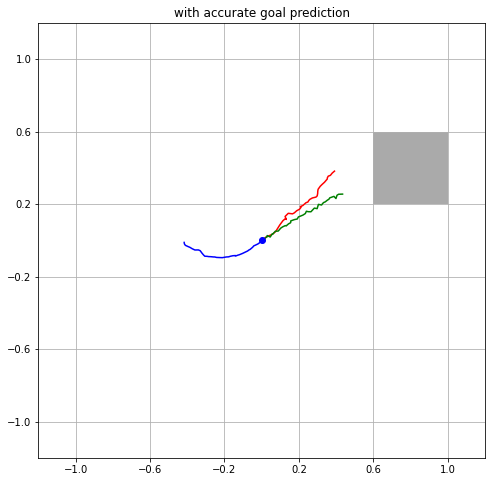

In [14]:

N = 0
visualization.draw_path(eval_data_x[N], eval_data_y[N], prediction_model=model_no_goal, name="no goal prediction")
visualization.draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model_goal, name="with accurate goal prediction")